# Scripts for coursework
## Step 1. Preparing data

In [1]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import xmltodict, csv, graphviz
import pm4py

### Reading input & extracting problems

In [2]:
# Reading input file
fd = open('external-43799.xml', 'r')
xml_file=fd.read()
fd.close()

soup=bs(xml_file, 'lxml')

# Preparing header for df_problems
cols = ["problem_title", "problem_name"]
rows = []

for tag in soup.findAll("problem"):
    title = tag["title"]
    name = tag["longname"]

    rows.append({"problem_title": title,
                 "problem_name": name})

df_problems = pd.DataFrame(rows, columns=cols)
df_problems = df_problems.set_index('problem_name')

# df_problems

### Extracting users

In [3]:
cols = ["user_id", "login", "user_name"]
rows = []

for tag in soup.findAll("user"):
    id = tag["id"]
    login = tag["loginname"]
    name = tag["displayedname"]

    rows.append({"user_id": id,
                 "login": login,
                 "user_name": name})

df_users = pd.DataFrame(rows, columns=cols)
df_users =df_users.set_index('user_id')

# df_users

### Extracting submits without tests and tests

In [4]:
# Preparing header for submits df
cols = ["contestTime", "absoluteTime", "lastUpdateTime", "id", "problem", "user", "lang", "maxTime", "maxMemory", "verdict"]
rows = []

# Preparing header for submit's tests df_tests
test_cols = ["submit_id", "number", "verdict", "time", "memory"]
test_rows = []

# Parsing input for submits (without tests)
for tag in soup.findAll("submit"):
    contestTime = tag["contesttime"]
    absoluteTime = tag["absolutetime"]
    lastUpdateTime = tag["lastupdatetime"]
    id = tag["id"]
    problem = tag["problemtitle"]
    user = tag["userid"]
    lang = tag["languageid"]
    time = tag["maxtimeusedmillis"]
    memory = tag["maxmemoryusedbytes"]
    verdict = tag["verdict"]
    
    for test in tag.findAll("test"):
        number = test["number"]
        t_verdict = test["verdict"]
        t_time = test["timeusedmillis"]
        t_memory = test["memoryusedbytes"]

        test_rows.append({"submit_id": id,
                          "number": number,
                          "verdict": t_verdict,
                          "time": t_time,
                          "memory": t_memory})
    
    rows.append({"contestTime": contestTime,
                 "absoluteTime": absoluteTime,
                 "lastUpdateTime": lastUpdateTime,
                 "id": id,
                 "problem": problem,
                 "user": user,
                 "lang": lang,
                 "maxTime": time,
                 "maxMemory": memory,
                 "verdict": verdict})
    
df = pd.DataFrame(rows, columns = cols)


df_tests = pd.DataFrame(test_rows, columns=test_cols)
df_tests = df_tests.set_index('submit_id')

# df

### Creating modified dataframes 
Different interpretations of verdicts:
- df: original dataframe with all verdicts
- df_hard: dataframe with OK as OK and others as FAIL verdicts (partial solution is FAIL)
- df_soft: dataframe with WA as FAIL and others as OK verdicts (partial solution is SUCCESS)

In [5]:
df_hard = df[['absoluteTime', 'problem', 'user', 'lang', 'maxTime', 'maxMemory', 'verdict']].copy()
# print(df_hard.groupby(['verdict'])['id'].count())
df_hard.verdict[df_hard.verdict != 'OK'] = 'FAIL'

# df_hard

In [6]:
df_soft = df[['absoluteTime', 'problem', 'user', 'lang', 'maxTime', 'maxMemory', 'verdict']].copy()
df_soft.verdict[df_soft.verdict != 'WA'] = 'OK'
df_soft.verdict[df_soft.verdict == 'WA'] = 'FAIL'

# df_soft

## Step 2. Building process models

### 2.1 Original dataset
Transforming dataframe to event log

In [7]:
format_df = df[['absoluteTime', 'problem', 'user', 'lang', 'maxTime', 'maxMemory', 'verdict']].copy()
format_df.problem = format_df.problem + ' ' + format_df.verdict
format_df = format_df.rename(columns = {'lang':'case:lang', 'maxTime':'case:maxTime', 'maxMemory':'case:maxMemory'})
format_df = pm4py.format_dataframe(format_df, case_id = 'user', activity_key = 'problem', timestamp_key='absoluteTime')
event_log = pm4py.convert_to_event_log(format_df)

# event_log

In [8]:
log_start = pm4py.get_start_activities(event_log)
# log_start

In [9]:
log_end = pm4py.get_end_activities(event_log)
# log_end

In [10]:
variants = pm4py.get_variants_as_tuples(event_log)
#variants

In [11]:
net, im, fm = pm4py.discover_petri_net_alpha(event_log)
# pm4py.view_petri_net(net, im, fm, format='png')

In [12]:
net_ind, im_ind, fm_ind = pm4py.discover_petri_net_inductive(event_log, noise_threshold=0.2)
# pm4py.view_petri_net(net_ind, im_ind, fm_ind, format='png')

In [13]:
places = net_ind.places
transitions = net_ind.transitions
arcs = net_ind.arcs

# for place in places:
#     print("\nPLACE: "+place.name)
#     for arc in place.in_arcs:
#         print(arc.source.name, arc.source.label)

In [14]:
process_tree = pm4py.discover_process_tree_inductive(event_log, noise_threshold=0.2)
# pm4py.view_process_tree(process_tree, format ='png')

In [15]:
bpmn_graph = pm4py.discover_bpmn_inductive(event_log, noise_threshold=0.2)
# pm4py.view_bpmn(bpmn_graph, format = 'png')

In [16]:
dfg, sa, ea = pm4py.discover_directly_follows_graph(event_log)
# pm4py.view_dfg(dfg, sa, ea, format='png')

In [17]:
fitness_a = pm4py.fitness_alignments(event_log, net, im, fm)

aligning log, completed variants :: 100%|██████████| 57/57 [00:01<00:00, 50.61it/s]


In [18]:
fitness_a_ind = pm4py.fitness_alignments(event_log, net_ind, im_ind, fm_ind)

aligning log, completed variants :: 100%|██████████| 57/57 [00:05<00:00, 10.10it/s]


In [40]:
precision_a = pm4py.precision_alignments(event_log, net, im, fm)

computing precision with alignments, completed variants :: 100%|██████████| 292/292 [00:00<00:00, 313.73it/s]


In [41]:
precision_a_ind = pm4py.precision_alignments(event_log, net_ind, im_ind, fm_ind)

computing precision with alignments, completed variants :: 100%|██████████| 292/292 [00:06<00:00, 47.19it/s]


In [49]:
precision_f_pt = pm4py.precision_footprints(event_log, process_tree)
precision_f_dfg = pm4py.precision_footprints(event_log, dfg)
precision_f_pt, precision_f_dfg

(0.18993506493506493, 1.0)

In [19]:
# pm4py.save_vis_petri_net(net, im, fm, 'petri_net.png')
# pm4py.save_vis_petri_net(net_ind, im_ind, fm_ind, 'petri_net_ind.png')
# pm4py.save_vis_process_tree(process_tree, 'process_tree_ind.png')
# pm4py.save_vis_bpmn(bpmn_graph, 'bpmn_ind.png')
# pm4py.save_vis_dfg(dfg, sa, ea, 'dfg.png')

### 2.2 Hard dataset
Transforming dataframe into event log

In [20]:
format_df_hard = df_hard[['absoluteTime', 'problem', 'user', 'lang', 'maxTime', 'maxMemory', 'verdict']].copy()
format_df_hard.verdict = format_df_hard.problem + ' ' + format_df_hard.verdict
format_df_hard = format_df_hard.rename(columns = {'lang':'case:lang', 'maxTime':'case:maxTime', 'maxMemory':'case:maxMemory'})
format_df_hard = pm4py.format_dataframe(format_df_hard, case_id = 'user', activity_key = 'verdict', timestamp_key='absoluteTime')
event_log_hard = pm4py.convert_to_event_log(format_df_hard)

# event_log_hard

In [21]:
log_start_hard = pm4py.get_start_activities(event_log_hard)
log_start_hard

{'A OK': 38, 'A FAIL': 20, 'D OK': 1, 'B OK': 1}

In [22]:
log_end_hard = pm4py.get_end_activities(event_log_hard)
# log_end_hard

In [23]:
variants_hard = pm4py.get_variants_as_tuples(event_log_hard)
#variants_hard

In [24]:
net_hard, im_hard, fm_hard = pm4py.discover_petri_net_alpha(event_log_hard)
# pm4py.view_petri_net(net_hard, im_hard, fm_hard, format='png')

In [25]:
net_ind_hard, im_ind_hard, fm_ind_hard = pm4py.discover_petri_net_inductive(event_log_hard)
# pm4py.view_petri_net(net_ind_hard, im_ind_hard, fm_ind_hard, format='png')

In [26]:
process_tree_hard = pm4py.discover_process_tree_inductive(event_log_hard)
# pm4py.view_process_tree(process_tree_hard, format ='png')

In [27]:
bpmn_graph_hard = pm4py.discover_bpmn_inductive(event_log_hard)
# pm4py.view_bpmn(bpmn_graph_hard, format = 'png')

In [28]:
dfg_hard, sa_hard, ea_hard = pm4py.discover_directly_follows_graph(event_log_hard)
# pm4py.view_dfg(dfg_hard, sa_hard, ea_hard, format='png')

In [29]:
# pm4py.save_vis_petri_net(net_hard, im_hard, fm_hard, 'petri_net_hard.png')
# pm4py.save_vis_petri_net(net_ind_hard, im_ind_hard, fm_ind_hard, 'petri_net_ind_hard.png')
# pm4py.save_vis_process_tree(process_tree_hard, 'process_tree_ind_hard.png')
# pm4py.save_vis_bpmn(bpmn_graph_hard, 'bpmn_ind_hard.png')
# pm4py.save_vis_dfg(dfg_hard, sa_hard, ea_hard, 'dfg_hard.png')

### 2.3 Soft dataset
Transforming dataframe to event log

In [30]:
format_df_soft = df_soft[['absoluteTime', 'problem', 'user', 'lang', 'maxTime', 'maxMemory', 'verdict']].copy()
format_df_soft.verdict = format_df_soft.problem + ' ' + format_df_soft.verdict
format_df_soft = format_df_soft.rename(columns = {'lang':'case:lang', 'maxTime':'case:maxTime', 'maxMemory':'case:maxMemory'})
format_df_soft = pm4py.format_dataframe(format_df_soft, case_id = 'user', activity_key = 'verdict', timestamp_key='absoluteTime')
event_log_soft = pm4py.convert_to_event_log(format_df_soft)

# event_log_soft

In [31]:
log_start_soft = pm4py.get_start_activities(event_log_soft)
# log_start_soft

In [32]:
log_end_soft = pm4py.get_end_activities(event_log_soft)
# log_end_soft

In [33]:
net_soft, im_soft, fm_soft = pm4py.discover_petri_net_alpha(event_log_soft)
# pm4py.view_petri_net(net_soft, im_soft, fm_soft, format='png')

In [34]:
net_ind_soft, im_ind_soft, fm_ind_soft = pm4py.discover_petri_net_inductive(event_log_soft)
# pm4py.view_petri_net(net_ind_soft, im_ind_soft, fm_ind_soft, format='png')

In [35]:
process_tree_soft = pm4py.discover_process_tree_inductive(event_log_soft)
# pm4py.view_process_tree(process_tree_soft, format ='png')

In [36]:
bpmn_graph_soft = pm4py.discover_bpmn_inductive(event_log_soft)
# pm4py.view_bpmn(bpmn_graph_soft, format = 'png')

In [37]:
dfg_soft, sa_soft, ea_soft = pm4py.discover_directly_follows_graph(event_log_soft)
# pm4py.view_dfg(dfg_soft, sa_soft, ea_soft, format='png')

In [38]:
# pm4py.save_vis_petri_net(net_soft, im_soft, fm_soft, 'petri_net_soft.png')
# pm4py.save_vis_petri_net(net_ind_soft, im_ind_soft, fm_ind_soft, 'petri_net_ind_soft.png')
# pm4py.save_vis_process_tree(process_tree_soft, 'process_tree_ind_soft.png')
# pm4py.save_vis_bpmn(bpmn_graph_soft, 'bpmn_ind_soft.png')
# pm4py.save_vis_dfg(dfg_soft, sa_soft, ea_soft, 'dfg_soft.png')

## Step 3. Experiments with logs

### Verdicts without problems

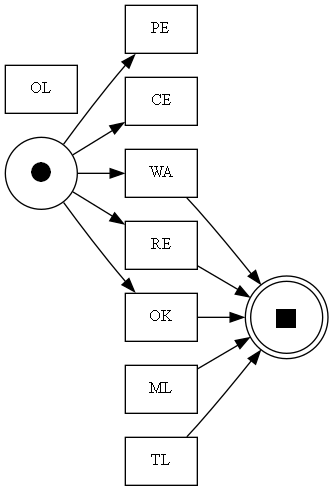

In [51]:
df_v = df[['absoluteTime', 'problem', 'user', 'lang', 'maxTime', 'maxMemory', 'verdict']].copy()
df_v = df_v.rename(columns = {'lang':'case:lang', 'maxTime':'case:maxTime', 'maxMemory':'case:maxMemory', 'problem':'case:problem'})
df_v = pm4py.format_dataframe(df_v, case_id = 'user', activity_key = 'verdict', timestamp_key='absoluteTime')
log_v = pm4py.convert_to_event_log(df_v)

net_v, im_v, fm_v = pm4py.discover_petri_net_alpha(log_v)
# pm4py.view_petri_net(net_v, im_v, fm_v, format='png')

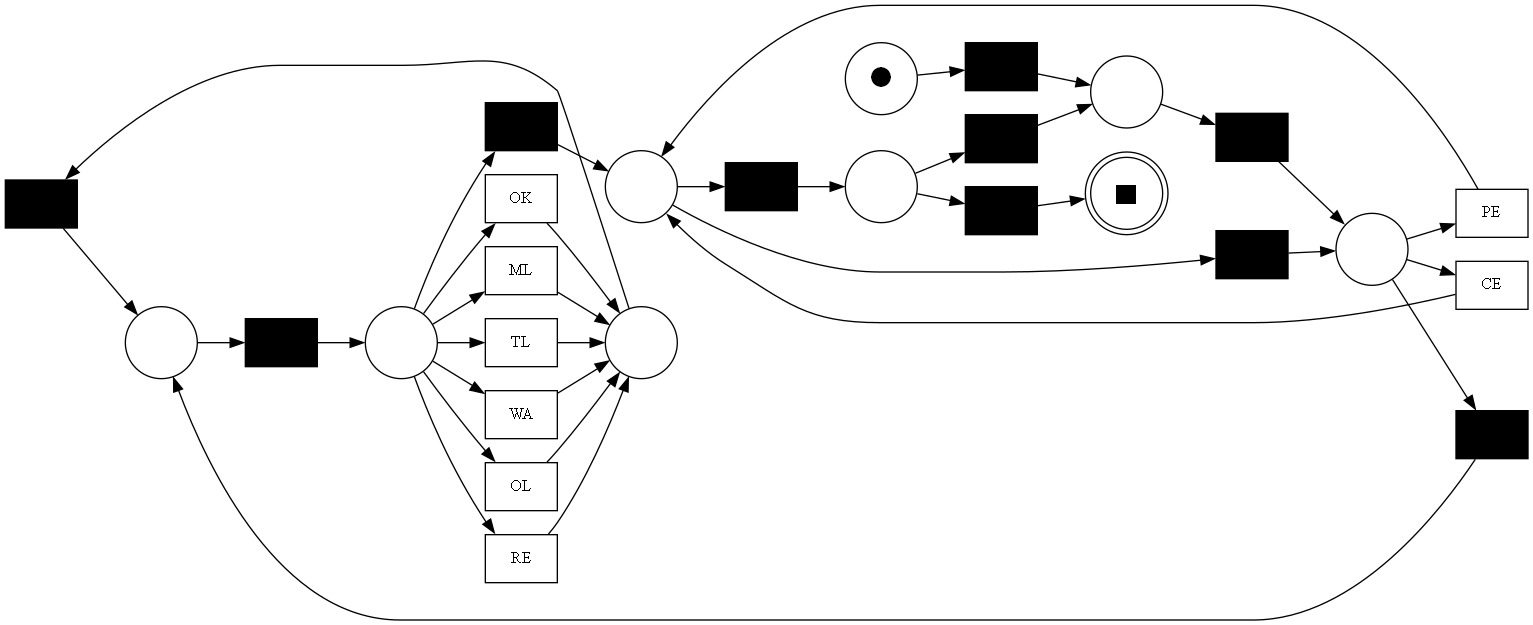

In [54]:
net_v_ind, im_v_ind, fm_v_ind = pm4py.discover_petri_net_inductive(log_v)
# pm4py.view_petri_net(net_v_ind, im_v_ind, fm_v_ind, format='png')

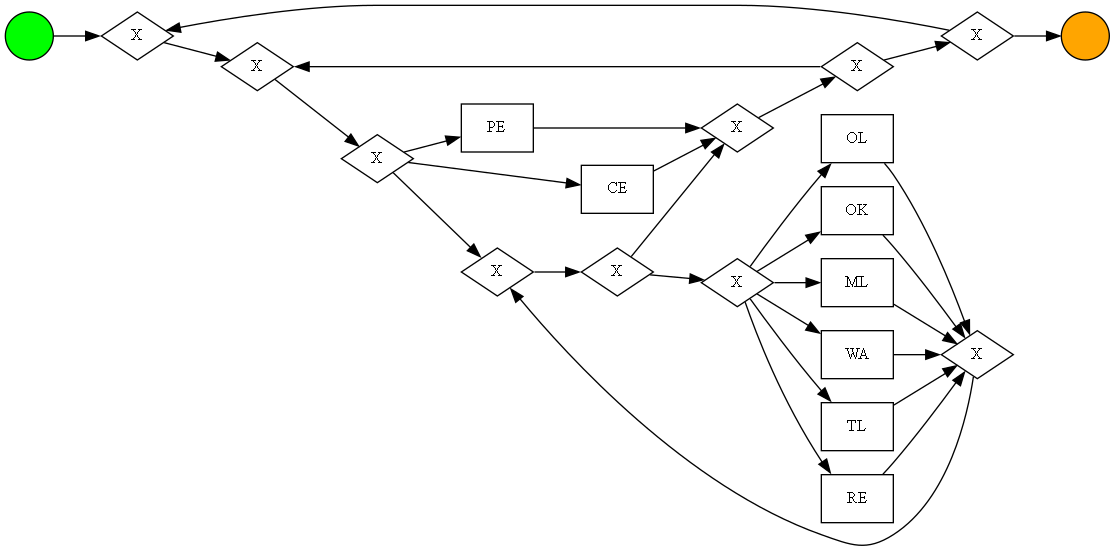

In [58]:
bpmn_graph_v = pm4py.discover_bpmn_inductive(log_v)
pm4py.view_bpmn(bpmn_graph_v, format = 'png')

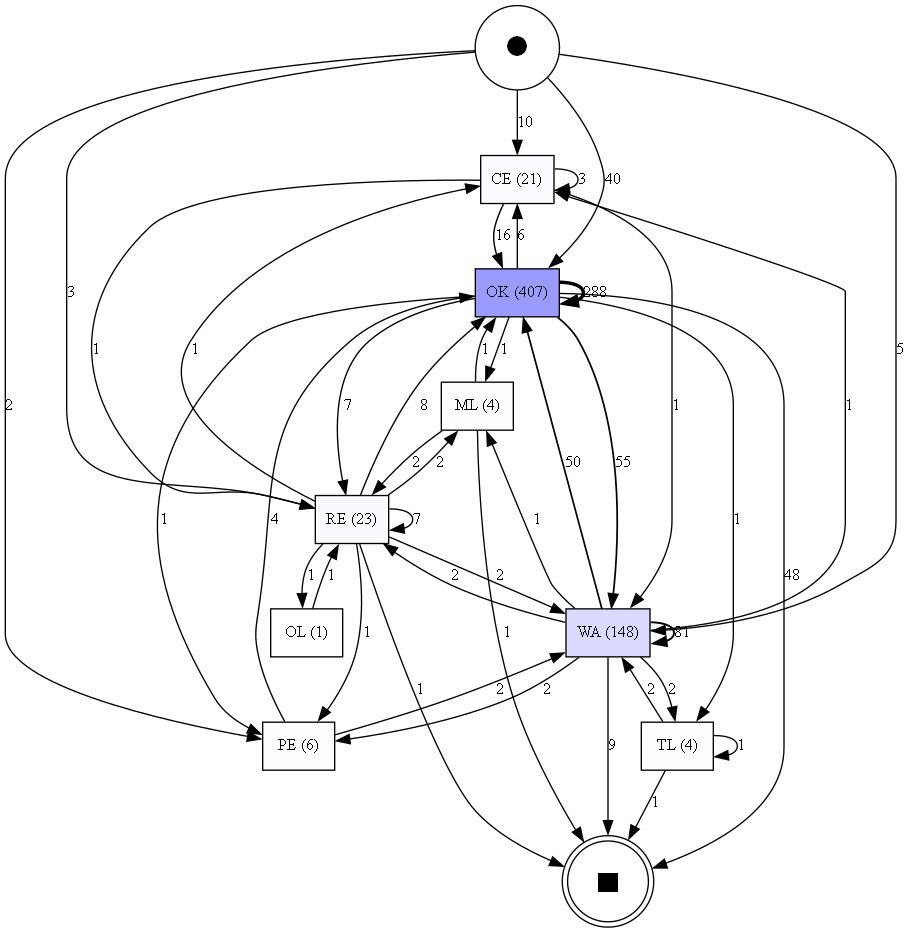

In [59]:
dfg_v, sa_v, ea_v = pm4py.discover_directly_follows_graph(log_v)
pm4py.view_dfg(dfg_v, sa_v, ea_v, format='png')

In [60]:
# pm4py.save_vis_petri_net(net_v, im_v, fm_v, 'petri_net_v.png')
# pm4py.save_vis_petri_net(net_v_ind, im_v_ind, fm_v_ind, 'petri_net_v_ind.png')
# pm4py.save_vis_bpmn(bpmn_graph_v, 'bpmn_v.png')
# pm4py.save_vis_dfg(dfg_v, sa_v, ea_v, 'dfg_v.png')

### Problems without verdicts

In [69]:
df_p = df[['absoluteTime', 'problem', 'user', 'lang', 'maxTime', 'maxMemory', 'verdict']].copy()
df_p = df_p.rename(columns = {'lang':'case:lang', 'maxTime':'case:maxTime', 'maxMemory':'case:maxMemory', 'verdict':'case:verdict'})
df_p = pm4py.format_dataframe(df_p, case_id = 'user', activity_key = 'problem', timestamp_key='absoluteTime')
log_p = pm4py.convert_to_event_log(df_p)

# log_p

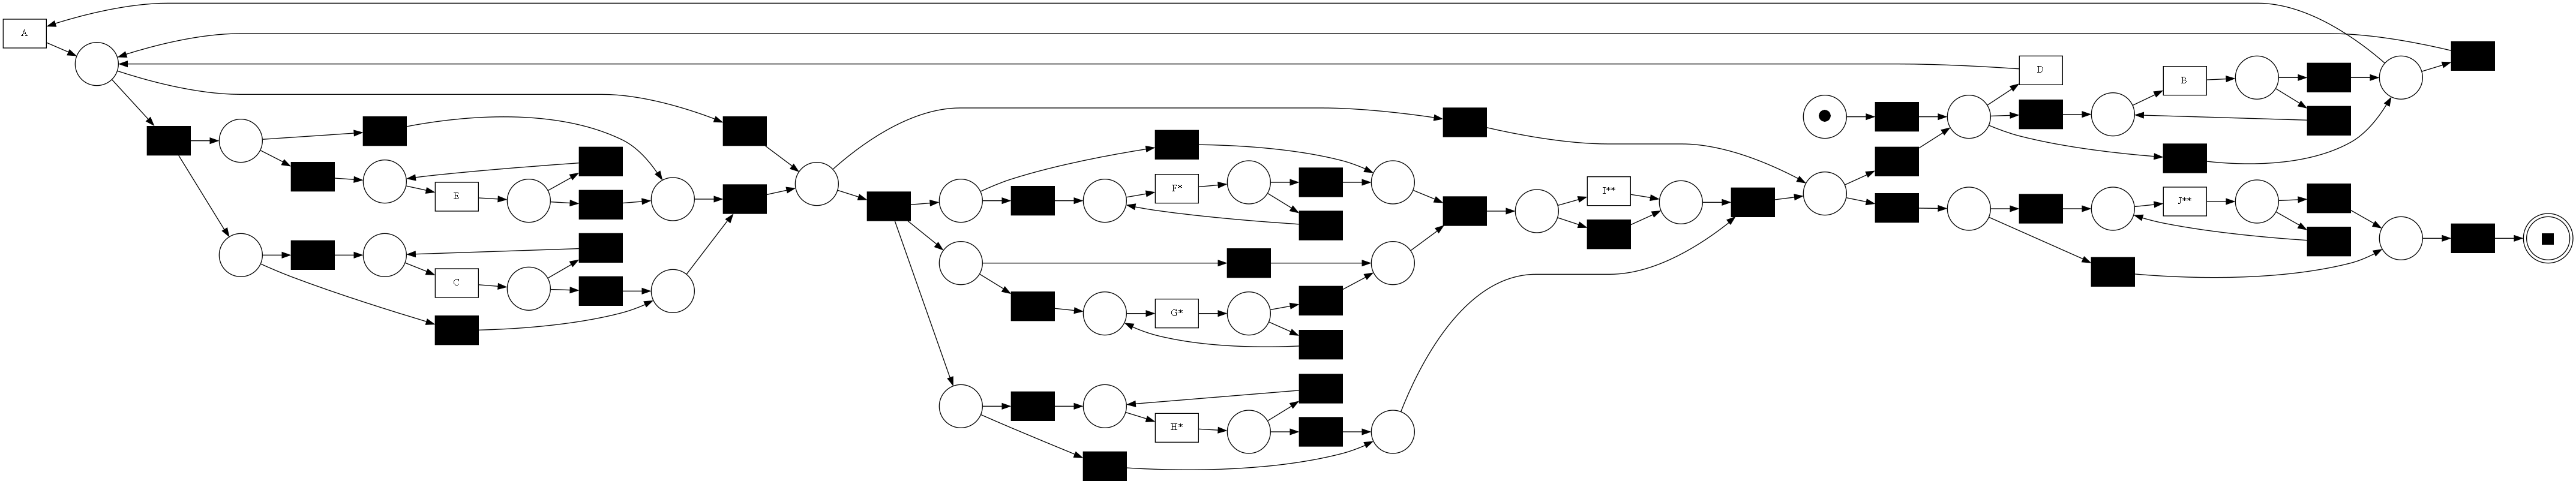

In [65]:
net_p_ind, im_p_ind, fm_p_ind = pm4py.discover_petri_net_inductive(log_p)
pm4py.view_petri_net(net_p_ind, im_p_ind, fm_p_ind, format='png')

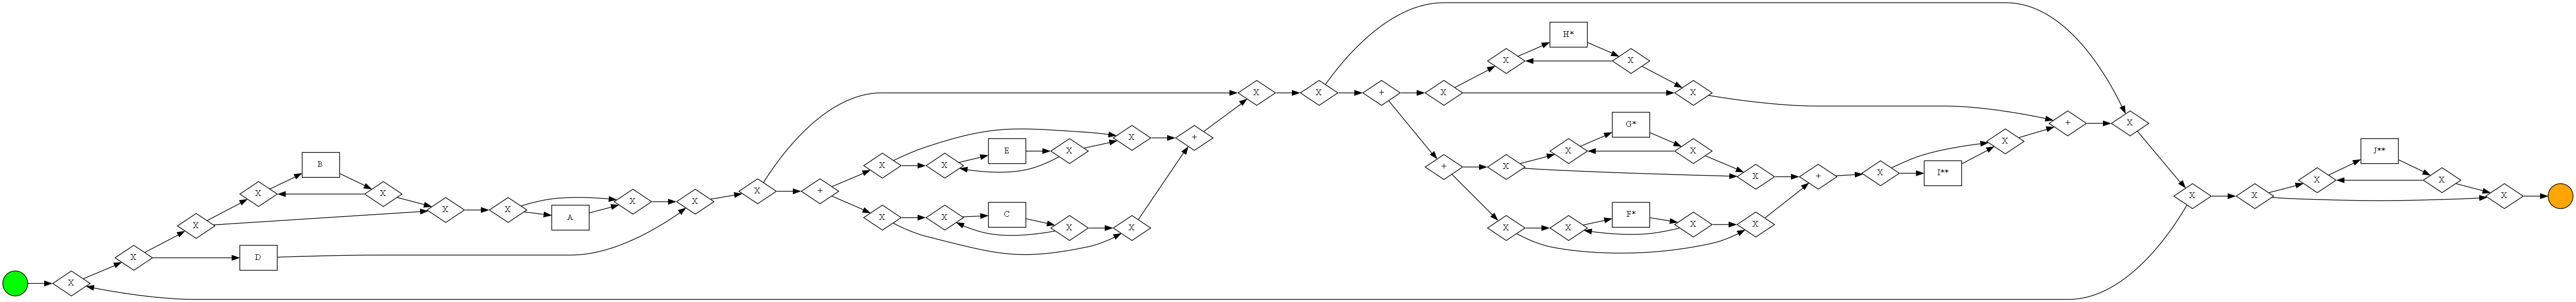

In [66]:
bpmn_graph_p = pm4py.discover_bpmn_inductive(log_p)
pm4py.view_bpmn(bpmn_graph_p, format = 'png')

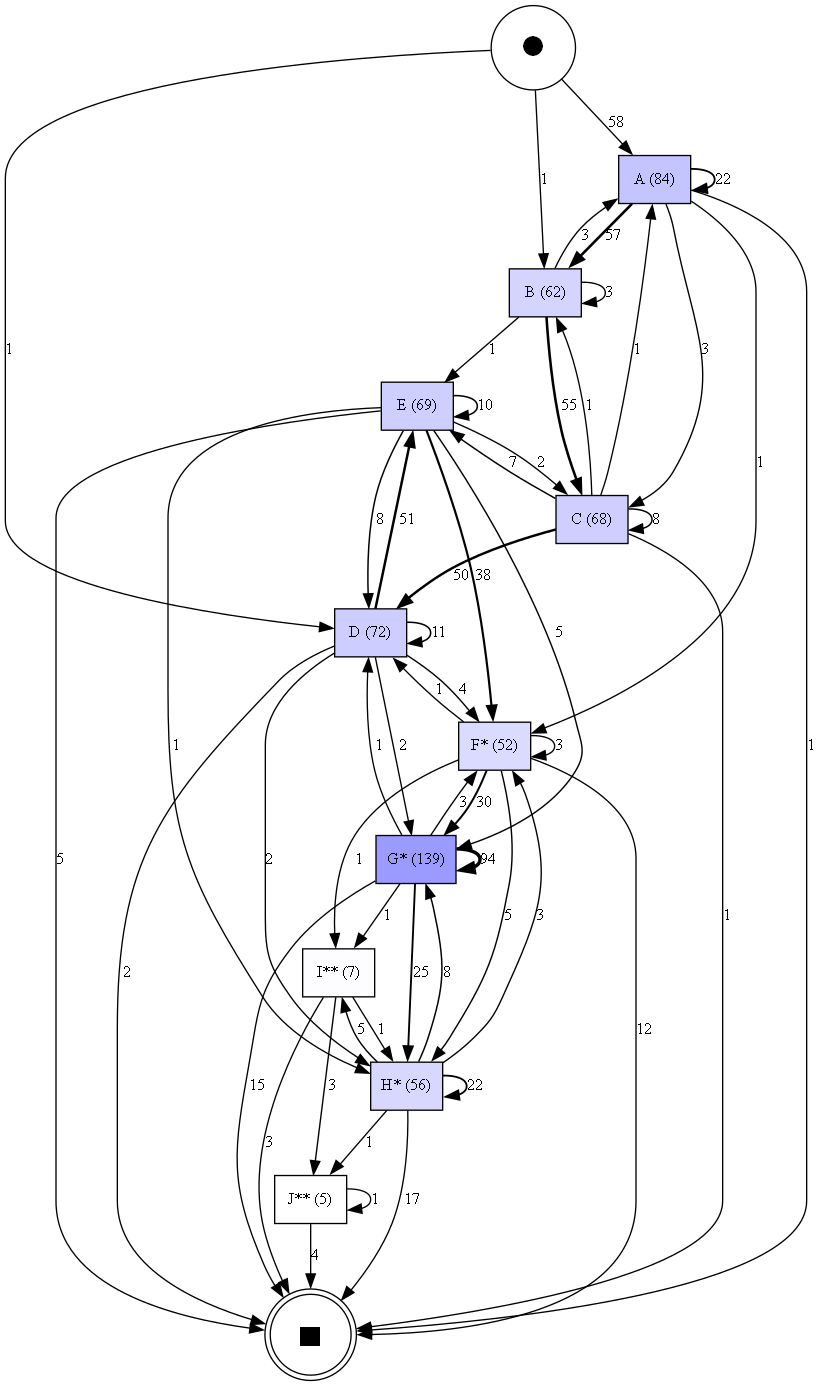

In [67]:
dfg_p, sa_p, ea_p = pm4py.discover_directly_follows_graph(log_p)
pm4py.view_dfg(dfg_p, sa_p, ea_p, format='png')

In [68]:
# pm4py.save_vis_petri_net(net_p, im_p, fm_p, 'petri_net_p.png')
# pm4py.save_vis_petri_net(net_p_ind, im_p_ind, fm_p_ind, 'petri_net_p_ind.png')
# pm4py.save_vis_bpmn(bpmn_graph_p, 'bpmn_p.png')
# pm4py.save_vis_dfg(dfg_p, sa_p, ea_p, 'dfg_p.png')